Group Members: Asha Karmakar, Akhil Iyer, Megan Sundheim, Grace Kim
Asha -
Grace -
Akhil - 
Megan - 

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import random

<p> https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features </p>

<h1> Data Preprocessing & Exploration </h1>

In [3]:
# Read in csv file
df = pd.read_csv("./data/genres.csv")

/var/folders/pg/jgps72r91276npng3bqr2zg40000gn/T/ipykernel_1457/3599437126.py:2: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./data/genres.csv")


In [4]:
# Clean data
# Remove the following columns: type, id, uri, track_href, analysis_url, unnamed, title, song_name
df = df[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'genre']]

In [5]:
# one hot encode time signature
df = pd.get_dummies(df, columns=['time_signature'], drop_first=False)

print (df)
print(df.shape)

       danceability  energy  key  loudness  mode  speechiness  acousticness  \
0             0.831   0.814    2    -7.364     1       0.4200      0.059800   
1             0.719   0.493    8    -7.230     1       0.0794      0.401000   
2             0.850   0.893    5    -4.783     1       0.0623      0.013800   
3             0.476   0.781    0    -4.710     1       0.1030      0.023700   
4             0.798   0.624    2    -7.668     1       0.2930      0.217000   
...             ...     ...  ...       ...   ...          ...           ...   
42300         0.528   0.693    4    -5.148     1       0.0304      0.031500   
42301         0.517   0.768    0    -7.922     0       0.0479      0.022500   
42302         0.361   0.821    8    -3.102     1       0.0505      0.026000   
42303         0.477   0.921    6    -4.777     0       0.0392      0.000551   
42304         0.529   0.945    9    -5.862     1       0.0615      0.001890   

       instrumentalness  liveness  valence    tempo

In [6]:
# Separate data into features and class labels
print(df.columns.get_loc('genre'))
features = pd.concat([df.iloc[:, :12], df.iloc[:, 13:]], axis=1)
labels = df.iloc[:, 12]
# .values.ravel()

12


In [7]:
# print (labels)
label_groups = df.groupby('genre')
print(len(label_groups.size()))

print (label_groups.size())

15
genre
Dark Trap          4578
Emo                1680
Hiphop             3028
Pop                 461
Rap                1848
RnB                2099
Trap Metal         1956
Underground Rap    5875
dnb                2966
hardstyle          2936
psytrance          2961
techhouse          2975
techno             2956
trance             2999
trap               2987
dtype: int64


In [8]:
# There are no missing values:
null_data = df[df.isnull().any(axis=1)]
len(null_data)

0

[Text(0.5, 0, 'danceability'),
 Text(1.5, 0, 'energy'),
 Text(2.5, 0, 'key'),
 Text(3.5, 0, 'loudness'),
 Text(4.5, 0, 'mode'),
 Text(5.5, 0, 'speechiness'),
 Text(6.5, 0, 'acousticness'),
 Text(7.5, 0, 'instrumentalness'),
 Text(8.5, 0, 'liveness'),
 Text(9.5, 0, 'valence'),
 Text(10.5, 0, 'tempo'),
 Text(11.5, 0, 'duration_ms'),
 Text(12.5, 0, 'time_signature_1'),
 Text(13.5, 0, 'time_signature_3'),
 Text(14.5, 0, 'time_signature_4'),
 Text(15.5, 0, 'time_signature_5')]

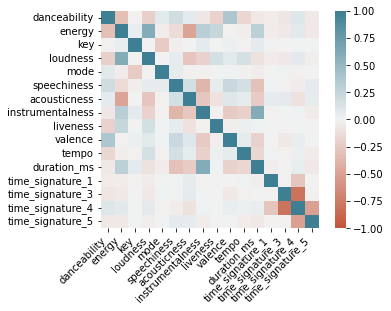

In [9]:
import seaborn as sns

# correlation between features

ax = sns.heatmap(
    features.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

In [10]:
# Perform Anomaly Detection
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

y_pred_list = []

envelope_pred = EllipticEnvelope().fit_predict(features)
y_pred_list.append(envelope_pred)

# apply IsolationForest AD
forest_pred = IsolationForest().fit_predict(features)
y_pred_list.append(forest_pred)

# apply LocalOutlierFactor AD
lof_pred = LocalOutlierFactor().fit_predict(features)
y_pred_list.append(lof_pred)

y_pred_list

[array([ 1, -1, -1, ...,  1,  1,  1]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([1, 1, 1, ..., 1, 1, 1])]

In [11]:
from collections import Counter

for arr in y_pred_list:
    c = Counter(arr)
    print(c)

Counter({1: 38074, -1: 4231})
Counter({1: 37410, -1: 4895})
Counter({1: 40473, -1: 1832})


In [12]:
# Need to standardize for PCA.
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaled_data = StandardScaler().fit_transform(features.values)
music_data_scaled = pd.DataFrame(scaled_data, columns=features.columns)
music_data_scaled.head()

print("num features before PCA: ", len(features.columns))

# your code goes here
pca = PCA(n_components=0.95, svd_solver='full')
pca_data = pca.fit_transform(music_data_scaled)
music_data_pca = pd.DataFrame(pca_data)
music_data_pca.head()

print("num features after PCA: ", len(music_data_pca.columns))

num features before PCA:  16
num features after PCA:  13


In [13]:
# Perform decision tree classification before PCA and then perform another decision tree after PCA

import sklearn.model_selection as ms

x_train, x_test, y_train, y_test = ms.train_test_split(features, labels, test_size=0.2)

print("Number of records in training set:", len(x_train.index))
print("Number of records in test set:", len(x_test.index))

Number of records in training set: 33844
Number of records in test set: 8461


<h1> Model Building </h1>

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

param_grid = {
    'pca__n_components': list(range(5, 16)),
    'knn__n_neighbors': list(range(1, 25))
}


knn_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()), ('knn', KNeighborsClassifier())])

knn_gscv = GridSearchCV(estimator=knn_pipe, param_grid=param_grid, scoring='accuracy', cv=5)

knn_gscv.fit(features, labels)

print("GridSearchCV Best Params: ", knn_gscv.best_params_)
print("GridSearchCV Best Score", knn_gscv.best_score_)

GridSearchCV Best Params:  {'knn__n_neighbors': 18, 'pca__n_components': 15}
GridSearchCV Best Score 0.5798072460078225


In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import MDS

kmeans = KMeans(n_clusters=15)
kpred = kmeans.fit_predict(music_data_pca)
sil_score = silhouette_score(music_data_pca, kpred, metric='euclidean')

print (sil_score)


0.14737579928744093


In [33]:
import numpy as np
from math import e
import pandas as pd   

""" Usage: pandas_entropy(df['column1']) """

# Based on StackOverflow post: https://stackoverflow.com/questions/49685591/how-to-find-the-entropy-of-each-column-of-data-set-by-python
def pandas_gini(column, base=None):
    vc = pd.Series(column).value_counts(sort=False)
    base = e if base is None else base
    return 1 - (np.square((vc / len(column)))).sum()

entropies = []
cluster_labels = []
cluster_names = []

for k in range(0, 15):

    filtered_cluster = labels[kpred == k]

    lbl = filtered_cluster.value_counts(sort=False).argmax()
    genre_cf = filtered_cluster.mode()
    cluster_labels.append(lbl)
    cluster_names.append(genre_cf.values[0])

    entropies.append(pandas_gini(filtered_cluster, base=e))

print(cluster_names)
print(cluster_labels)
print (entropies)

['techno', 'psytrance', 'techhouse', 'Dark Trap', 'dnb', 'Dark Trap', 'hardstyle', 'Dark Trap', 'Dark Trap', 'Underground Rap', 'Underground Rap', 'trap', 'Underground Rap', 'techno', 'Underground Rap']
[8, 11, 8, 0, 13, 0, 14, 0, 0, 1, 1, 11, 1, 8, 1]
[0.8036170210208877, 0.8736329172695759, 0.7986491838787506, 0.9001003391071501, 0.861547269298355, 0.8652444444444445, 0.8214397678902673, 0.8316127539451155, 0.8552614819303616, 0.8215896168260073, 0.7861901938905292, 0.7708115702479339, 0.7971815029051406, 0.7514789164712238, 0.7189760500654754]


             0         1         2         3         4         5         6   \
15     2.925831 -1.776284  1.877886 -0.418875 -0.154441  0.247078 -0.145090   
28     1.166840 -2.026947  1.844830 -2.490360  0.283055  0.116299  0.080003   
41     0.719262 -1.341728  2.655935  0.709740 -0.990527  0.176184 -0.115030   
43     1.044596 -1.387287  1.038922 -1.874892 -0.234662  0.149084 -0.037226   
60     0.159353 -1.303876  2.883427  1.809596 -0.799714 -0.107919 -0.071715   
...         ...       ...       ...       ...       ...       ...       ...   
42182 -0.707537 -1.318894  2.395927 -0.045860 -0.344960  0.258812 -0.078825   
42194 -0.710954 -1.036943  2.077517  1.179472  0.793457  0.233690 -0.078903   
42248 -0.286140 -1.052024  2.270314  1.236574  0.042827  0.212166 -0.114587   
42294 -0.527956 -1.321609  2.436983 -0.804718 -1.069988  0.265466 -0.101945   
42296 -0.227345 -0.969016  1.899997  1.418781  0.491445  0.264053 -0.172543   

             7         8         9         10      

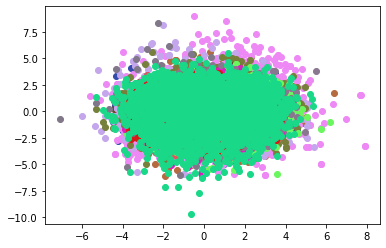

In [18]:

colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(15)]

for k in range(0, 15):

    filtered_label0 = music_data_pca[kpred == k]
    
    color = colors[k]

    mds = MDS(n_components=2)
    mds_data = mds.fit_transform(filtered_label0)
    plt.scatter(mds_data[:,0] , mds_data[:,1], c=color)
    plt.show()

plt.show()

In [21]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, cophenet

centers = kmeans.cluster_centers_

proximity_matrix = pdist(centers)
methods = ['single', 'complete', 'average', 'centroid', 'ward']
cpccs = []
# the rest of your code goes here

# Compute correlation for every linkage method and get the method with highest corr
for method in methods:
    link_matrix = linkage(centers, method)
    cpcc, _ = cophenet(link_matrix, proximity_matrix)
    cpccs.append(cpcc)

print ("The ", methods[np.argmax(cpccs)], "method worked best since it had the\
       highest CPCC of", np.amax(cpccs))

The  average method worked best since it had the       highest CPCC of 0.9959921493441718


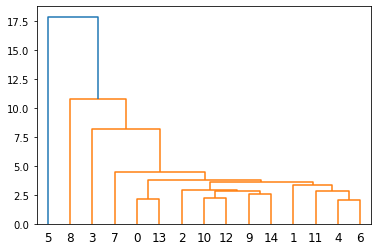

In [22]:
hier = linkage(centers, 'average')
plt.figure()
dn = dendrogram(hier)
plt.show()

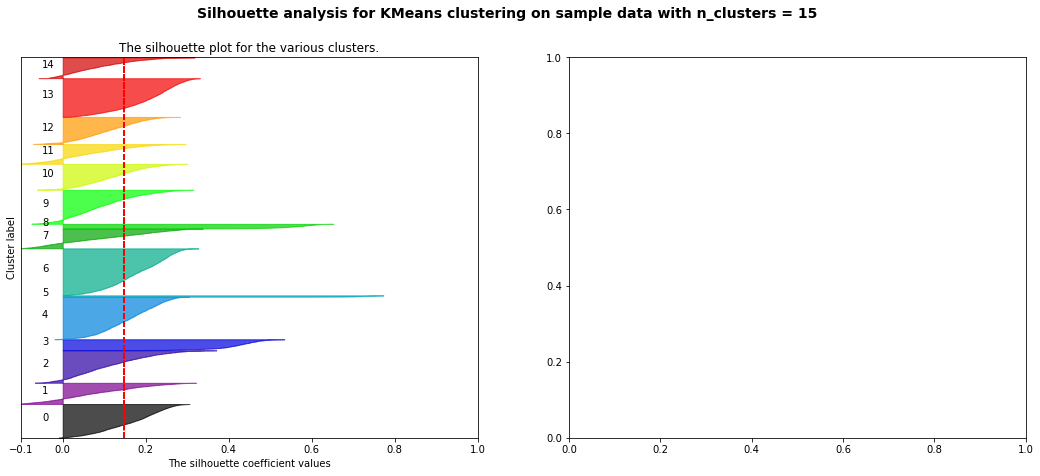

In [43]:
# Code adapted from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

n_clusters = 15
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(music_data_pca) + (n_clusters + 1) * 10])

# kpred2 = KMeans(n_clusters=2).fit_predict(music_data_pca)

avg_sil_score = silhouette_score(music_data_pca, kpred, metric='euclidean')
sample_silhouette_values = silhouette_samples(music_data_pca, kpred)

# avg_sil_score = silhouette_score(music_data_pca, kpred, metric='euclidean')
# sample_silhouette_values = silhouette_samples(music_data_pca, kpred)

y_lower = 10
for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[kpred == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=avg_sil_score, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()


In [37]:
kmeans_sil_scores = []
for i in range(2, 16):
    ith_kmeans = KMeans(n_clusters=i)
    ith_kpred = ith_kmeans.fit_predict(music_data_pca)
    ith_sil_score = silhouette_score(music_data_pca, ith_kpred, metric='euclidean')
    kmeans_sil_scores.append(ith_sil_score)

print ("Best K for K-Means Clustering: ", np.argmax(kmeans_sil_scores) + 2)
print ("Highest silhouette score", np.amax(kmeans_sil_scores))

Best K for K-Means Clustering:  0
Highest silhouette score 0.5456889802400375


In [39]:
print ("Best K for K-Means Clustering: ", np.argmax(kmeans_sil_scores) + 2)
print ("Highest silhouette score", np.amax(kmeans_sil_scores))

print (kmeans_sil_scores)

Best K for K-Means Clustering:  2
Highest silhouette score 0.5456889802400375
[0.5456889802400375, 0.1599691083855437, 0.14887880050306482, 0.1617228084081758, 0.16762597695691334, 0.16333103846737923, 0.1571374737187522, 0.15891323745512717, 0.1515981983665475, 0.15166960993792936, 0.1434889939926793, 0.1450585027149235, 0.14559714675892094, 0.1454648615818637]


In [40]:
for i in range(16, 31):
    ith_kmeans = KMeans(n_clusters=i)
    ith_kpred = ith_kmeans.fit_predict(music_data_pca)
    ith_sil_score = silhouette_score(music_data_pca, ith_kpred, metric='euclidean')
    kmeans_sil_scores.append(ith_sil_score)

print (kmeans_sil_scores)

[0.5456889802400375, 0.1599691083855437, 0.14887880050306482, 0.1617228084081758, 0.16762597695691334, 0.16333103846737923, 0.1571374737187522, 0.15891323745512717, 0.1515981983665475, 0.15166960993792936, 0.1434889939926793, 0.1450585027149235, 0.14559714675892094, 0.1454648615818637, 0.14780095918748867, 0.14767182108559737, 0.14278306843171165, 0.13957515418838307, 0.14127469420631633, 0.13467972649887464, 0.13599742137439697, 0.13391409260144457, 0.1352791899661597, 0.12992913964334132, 0.1298269204574592, 0.13115647262153934, 0.1287938516824271, 0.12952498826416392, 0.1299692653757187]


In [44]:
for i in range(32, 101):
    ith_kmeans = KMeans(n_clusters=i)
    ith_kpred = ith_kmeans.fit_predict(music_data_pca)
    ith_sil_score = silhouette_score(music_data_pca, ith_kpred, metric='euclidean')
    kmeans_sil_scores.append(ith_sil_score)

for score in kmeans_sil_scores:
    something = 2
    print (something, " ", score)
    something += 1

2   0.5456889802400375
2   0.1599691083855437
2   0.14887880050306482
2   0.1617228084081758
2   0.16762597695691334
2   0.16333103846737923
2   0.1571374737187522
2   0.15891323745512717
2   0.1515981983665475
2   0.15166960993792936
2   0.1434889939926793
2   0.1450585027149235
2   0.14559714675892094
2   0.1454648615818637
2   0.14780095918748867
2   0.14767182108559737
2   0.14278306843171165
2   0.13957515418838307
2   0.14127469420631633
2   0.13467972649887464
2   0.13599742137439697
2   0.13391409260144457
2   0.1352791899661597
2   0.12992913964334132
2   0.1298269204574592
2   0.13115647262153934
2   0.1287938516824271
2   0.12952498826416392
2   0.1299692653757187
2   0.13079195717375014
2   0.13212951888143964
2   0.13080227808381228
2   0.1285911593618763
2   0.13145771224427655
2   0.1316027013664609
2   0.13117633708510243
2   0.12841075775054178
2   0.12811478184375338
2   0.13045712882043964
2   0.13201604686427704
2   0.13044960638330022
2   0.12967512563259412
2   0.

In [45]:
print ("Best K for K-Means Clustering: ", np.argmax(kmeans_sil_scores) + 2)
print ("Highest silhouette score", np.amax(kmeans_sil_scores))

Best K for K-Means Clustering:  2
Highest silhouette score 0.5456889802400375


In [55]:
# Adapting K-Means for Supervised Clustering Algorithm

# def super_kmeans(train_set: pd.DataFrame, labels):

pca_df = pd.concat([music_data_pca, labels], axis = 1)
group_labels = df.groupby('genre')
all_genres = set(df['genre'].tolist())

# scaled_data = StandardScaler().fit_transform(features.values)
# music_data_scaled = pd.DataFrame(scaled_data, columns=features.columns)

# pca = PCA(n_components=0.95, svd_solver='full')
# pca_data = pca.fit_transform(music_data_scaled)
# music_data_pca = pd.DataFrame(pca_data)
# music_data_pca.head()

all_centroids = []

for genre in all_genres:
    cur_group = pca_df.get_group(genre)

    # scaled_group = pd.DataFrame(StandardScaler().fit_transform(features.values))
    # pca_group = pd.DataFrame(PCA(n_components=0.95, svd_solver='full').fit_transform(scaled_group))
    
    cur_kmeans = KMeans(n_clusters=5)
    kpred_genre = cur_kmeans.fit_predict(cur_group)
    for centroid in cur_kmeans.cluster_centers_:
        all_centroids.append(centroid)
    


      danceability  energy  key  loudness  mode  speechiness  acousticness  \
0            0.831   0.814    2    -7.364     1       0.4200       0.05980   
1            0.719   0.493    8    -7.230     1       0.0794       0.40100   
2            0.850   0.893    5    -4.783     1       0.0623       0.01380   
3            0.476   0.781    0    -4.710     1       0.1030       0.02370   
4            0.798   0.624    2    -7.668     1       0.2930       0.21700   
...            ...     ...  ...       ...   ...          ...           ...   
4573         0.639   0.821   10    -3.409     0       0.0478       0.05480   
4574         0.367   0.769    3    -4.548     0       0.0540       0.00683   
4575         0.587   0.530   10    -8.632     0       0.0330       0.05320   
4576         0.713   0.358    8   -12.249     1       0.1150       0.03750   
4577         0.734   0.628    5   -11.452     0       0.0569       0.13800   

      instrumentalness  liveness  valence    tempo  duration_ms